### Imports


In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.integrate import solve_ivp

In [2]:
from matplotlib.pyplot import style
import seaborn as sns

sns.set()
style.use('seaborn-talk')

### Define a Planet Class

In [3]:
class Planet:
    def __init__(self, e=0.0, a=0.0, omega=0.0, Omega=0.0, i=0.0, r_p=0.0, first_periastron=0):
        self.e = e  # eccentricity
        self.a = a  # semi major axis
        self.omega = omega  # argument of periapsis
        self.Omega = Omega  # longitude of ascending node
        self.i = i * (np.pi) / 180  # inclination
        self.r_p = r_p  # planet radius
        self.first_periastron = first_periastron  # time origin
        self.alphas = self.alpha_wrt_time(e=self.e, split=1000, first_periastron=self.first_periastron)

    def der_alpha(self, t, alpha, e):
        return (2 * np.pi / (1 - e * e)**1.5) * (1 + e * np.cos(alpha))**2

    def alpha_wrt_time(self, e=0.0, split=1000, first_periastron=0.0):
        split = int(split)
        t_span = (0.0, 1.0)
        t = np.linspace(0.0, 1.0, split + 1)
        y0 = np.array([0])
        sol = solve_ivp(self.der_alpha, t_span, y0, t_eval=t, args=(e,))
        alpha_array = sol.y[0]

        def alphas(time):
            nonlocal split, alpha_array
            time = (time - first_periastron) % 1.0
            n = time * split
            if int(n) < split:
                return alpha_array[int(n)]

        return alphas

    def getOrbitalElements(self):  # returns dictionary of Kepler Orbital elements
        return {'Eccentricity': self.e,
                'Semi Major Axis': self.a,
                'Argument of Periapsis': self.omega,
                'Longitude of Ascending Node': self.Omega,
                'Inclination': self.i}

    def getNu_from_time(self, time):  # returns true anomaly when time is inputted
        # use solutions of differential equation
        return self.alphas(time)

    def getPosition_from_nu(self, nu):  # returns position when true anomaly is inputted
        angle = nu + self.omega
        n_x = np.cos(angle)
        n_y = np.sin(angle) * np.cos(self.i)
        n_z = np.sin(angle) * np.sin(self.i)

        unit_vector = np.array([n_x, n_y, n_z])

        r = self.a * (1 - self.e**2) / (1 + self.e * np.cos(nu))

        position = np.array([r * unit_vector[0], r * unit_vector[1], r * unit_vector[2]])
        return position

    def getPosition(self, time):  # returns position when time is inputted
        return self.getPosition_from_nu(self.getNu_from_time(time))

    def setPeriod(self, period):
        self.period = period  # To be calculated in System

    def setSplit(self, split):
        self.alphas = self.alpha_wrt_time(e=self.e, split=split, first_periastron=self.first_periastron)

### Define a System class
The system class takes in each initialised planet as a list ('planet_list').

In [4]:
class System:
    def __init__(self, star_prop: dict, planet_list, sort=True):
        self.star_prop = star_prop
        if sort:
            self.planet_list = sorted(planet_list, key=lambda p: p.a)
        else:
            self.planet_list = planet_list
        self.img_split = 100
        self.time_split = 10000
        self.n = 2.0
        period_constant = (2 * np.pi) / ((scipy.constants.G * self.star_prop['Mass'] * 1.989e30)**0.5)
        for planet in self.planet_list:
            planet.setPeriod(period_constant * ((planet.a * 6.96e8)**1.5) / (36 * 24))  # days
        self.total_time = max([planet.period for planet in self.planet_list])
        for planet in self.planet_list:
            planet.setSplit(self.time_split * planet.period / self.total_time)

    def initialize_star(self, limb_func, split=1000):
        star = np.zeros((2 * split + 1, 2 * split + 1))
        total = 0
        for i in range(-split, split + 1):
            rg_j = abs(int((split**2 - i**2)**0.5))
            for j in range(-rg_j, rg_j + 1):
                x = (i) / split
                y = (j) / split
                cosine = abs((1 - x**2 - y**2)**0.5)
                lum = limb_func(cosine)
                total += lum
                star[split + i][split + j] = lum

        return star, total

    def lum_wrt_coord(self, img, tot):
        split = int((len(img) - 1) / 2)

        def shadow(coord_x, coord_y, R_p):
            nonlocal img, tot
            x, y, Rp = int(coord_x * split), int(coord_y * split), int(R_p * split)
            for i in range(-Rp, Rp + 1):
                if y - i >= -split and y - i <= split:
                    rg_j = abs(int((Rp**2 - i**2)**0.5))
                    for j in range(-rg_j, rg_j + 1):
                        if x + j >= -split and x + j <= split:
                            m = split - y + i
                            n = split + x + j
                            lum = img[m][n]
                            tot = tot - lum
                            img[m][n] = 0

        def lum():
            nonlocal tot
            return tot

        def star():
            nonlocal img
            return img

        return shadow, lum, star

    def limb_dark(self, cosine):
        if len(self.u) == 2:
            return 1 - self.u[0] * (1 - cosine) - self.u[1] * ((1 - cosine)**2)
        else:
            raise NameError('Check the u values')

    def getPosition(self, index, time):
        return self.planet_list[index].getPosition(time)

    def calc_lum(self, model='Quadratic', normalise=False):
        if model == 'Quadratic':
            self.u = [0.1, 0.2]
            self.star, self.total = self.initialize_star(limb_func=self.limb_dark, split=self.img_split)
        else:
            raise NameError("Model does not exist")
        self.timespan = np.linspace(0, int(self.n) * self.total_time, int(self.n) * self.time_split + 1)
        lum = []
        for timing in self.timespan:
            update, get_lum, get_star = self.lum_wrt_coord(copy.deepcopy(self.star), copy.deepcopy(self.total))
            for planet in self.planet_list:
                x, y, z = planet.getPosition(timing / planet.period)
                if y * (planet.i - (np.pi / 2)) > 0:  # Only the part of orbit which is away from us
                    continue
                if x**2 + y**2 > 2 * ((1 + planet.r_p)**2):
                    continue

                update(x, y, planet.r_p)
            lum.append(get_lum())
        lum = np.array(lum)
        if normalise:
            lum = lum / max(lum)
        return lum

    def plot(self, model='Quadratic', normalise=False):
        """Plot the transit curve"""
        lum = self.calc_lum(model, normalise)

        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)
        ax.scatter(self.timespan / 100, lum, s=1, c='b')
        ax.set_xlim(0, max(self.timespan) / 100)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set_xlabel('Time in days', fontsize=18)
        ax.set_ylabel('Relative luminosity', fontsize=18)
        ax.set_title('Transit Curve - {} Planet system'.format(len(self.planet_list)), fontsize=22)
        ax.grid(True)

        plt.show()

### Testing:

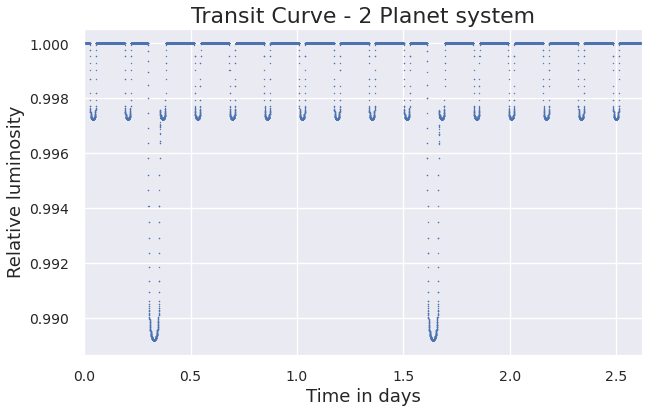

In [5]:
p1 = Planet(e=0.0, a=8, omega=0, Omega=0, i=89.9, r_p=0.1, first_periastron=0.0)
p2 = Planet(e=0.0, a=2, omega=0, Omega=0, i=89.9, r_p=0.05, first_periastron=0.0)
sys = System(star_prop={'Mass': 4}, planet_list=[p1,p2], sort=True)
sys.plot(model='Quadratic', normalise=True)